In [1]:
# prerequisite of forecasting is a stationary series
# if pure random, though stationary but impossible to forecast
# we need autocorrelation property

In [2]:
# Moving Average
# simple MA, weighted MA, exponential weighted MA

In [3]:
# AR(p) Model
# the autocorrelation coef may not be zero after several steps, hangover

In [4]:
# MA(q) model
# truncation
# so we can use correlation plot to see which model we should use

In [5]:
# ARMA(p,q)
# not only correlated with historical data, but also depends on historical noises
# modelling procedure: we analyze stationary series except white noise
# so 1st we must make a series to be stationary
#        then we must check if it is a white noise series
#    2nd we must decide p & q
#    3rd we should diagonize the model

In [2]:
# we use CPI data as an example to analyze
import pandas as pd 
CPI=pd.read_csv('CPI.csv',index_col='time')
CPI.index=pd.to_datetime(CPI.index)
[CPI.head(n=3),CPI.tail(n=3),CPI.shape]

[              CPI
 time             
 2014-05-01  100.1
 2014-04-01   99.7
 2014-03-01   99.5,               CPI
 time             
 2001-03-01   99.4
 2001-02-01  100.2
 2001-01-01  101.9, (161, 1)]

In [4]:
# split into train set and test set
# remove the last 3 data
CPItrain=CPI[3:]
CPItrain.head(n=3)

,CPI
time,
2014-02-01,100.5
2014-01-01,101.0
2013-12-01,100.3


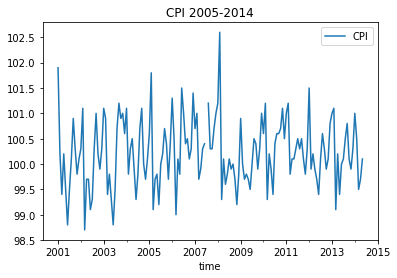

In [8]:
# time change plot
CPI.plot(title='CPI 2005-2014')

In [10]:
# loading ADF function
from arch.unitroot import ADF
# prevent p-value to be too low due to too large lag steps
CPItrain=CPItrain.dropna().CPI
print(ADF(CPItrain,max_lags=10).summary().as_text())
# under 5% we think it is stationary

True
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.900
P-value                         0.045
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [11]:
# next we check if it is pure random
# use LB test
from statsmodels.tsa import stattools
LjungBox=stattools.q_stat(stattools.acf(CPItrain)[1:12],len(CPItrain))
LjungBox[1][-1]
# very low p-value, so it is not a white noise series

0.00055601289485153623

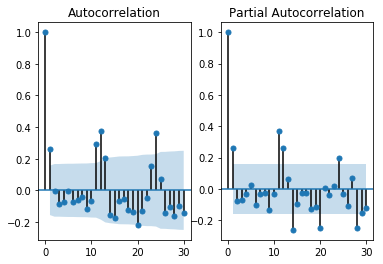

In [13]:
# modelling
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt
axe1=plt.subplot(121)
axe2=plt.subplot(122)
plot1=plot_acf(CPItrain,lags=30,ax=axe1)
plot2=plot_pacf(CPItrain,lags=30,ax=axe2)

In [14]:
# from plots above we know acf and pacf plots are all hangover tails, so p, q > 0
# but we do not know the exact value of p and q
# so we test all low order combinations of p and q, and use AIC principle to choose one
from statsmodels.tsa import arima_model
model1=arima_model.ARIMA(CPItrain,order=(1,0,1)).fit()
model1.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(1, 1)   Log Likelihood                -150.339
Method:                       css-mle   S.D. of innovations              0.630
Date:                Mon, 22 Oct 2018   AIC                            308.678
Time:                        11:08:26   BIC                            320.903
Sample:                             0   HQIC                           313.643
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2373      0.066   1516.139      0.000     100.108     100.367
ar.L1.CPI      0.0934      0.248      0.377      0.707      -0.392       0.579
ma.L1.CPI      0.1932      0.240      0.805      0.422      -0.277       0.664
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           10.7069           +0.0000j           10.7069            0.0000
MA.1           -5.1771           +0.0000j            5.1771            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
# other order models
model2=arima_model.ARIMA(CPItrain,order=(1,0,2)).fit()
model3=arima_model.ARIMA(CPItrain,order=(2,0,1)).fit()
model4=arima_model.ARIMA(CPItrain,order=(2,0,2)).fit()
model5=arima_model.ARIMA(CPItrain,order=(3,0,1)).fit()
model6=arima_model.ARIMA(CPItrain,order=(3,0,2)).fit()
# finally choose ARMA(3,2)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [16]:
# diagnise
# check if coefs are significant 
# check if residues are white noise, if so, it means we have extract enough informaiton from it
# if not, we shoulf modify our model
model6.conf_int()
# compute confidence interval
# all them do not contain zero, so they are all significant

,0,1
const,100.093868,100.379722
ar.L1.CPI,1.301692,1.609373
ar.L2.CPI,-1.478539,-1.109157
ar.L3.CPI,0.205484,0.503178
ma.L1.CPI,-1.313938,-1.183402
ma.L2.CPI,0.946969,1.053031


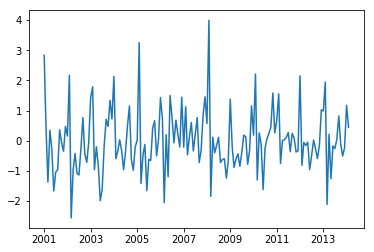

In [17]:
# then check residues
import math
stdresid=model6.resid/math.sqrt(model6.sigma2)
plt.plot(stdresid)

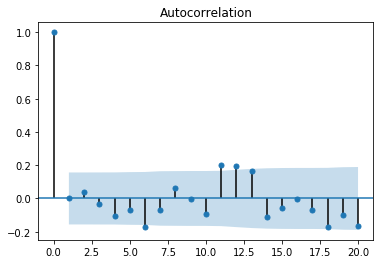

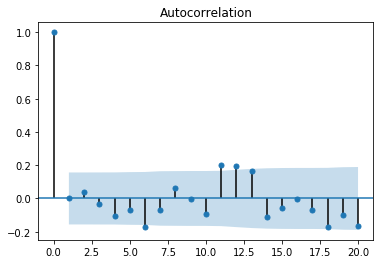

In [18]:
plot_acf(stdresid,lags=20)
# 11th and 12th are significant, so we add lag steps to do further check 

In [20]:
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:13],len(stdresid))
LjungBox[1][-1]
# < 0.05, not a white noise series

0.015722008260471137

In [21]:
# add lag steps
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:20],len(stdresid))
LjungBox[1][-1]
# after 12 steps, all < 0.05, not a white noise series

0.0034127327357241083

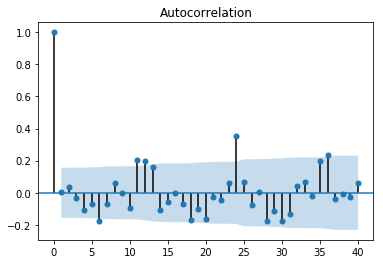

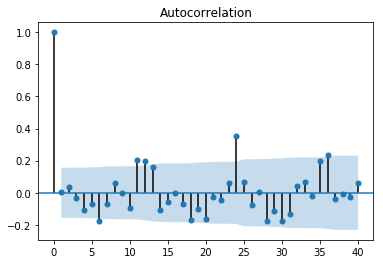

In [22]:
# add lag steps
plot_acf(stdresid,lags=40)
# obviously every 12 steps, the correlated relation becomes significant

In [23]:
# so we need ARIMA model, ARMA is not enough

In [24]:
# forecast
model6.forecast(3)[0]

array([ 100.49999723,  100.13102898,  100.3316309 ])

In [25]:
# compare with test data
CPI.head(3)

,CPI
time,
2014-05-01,100.1
2014-04-01,99.7
2014-03-01,99.5


In [30]:
# another example (modelling returns of a stock)
Datang=pd.read_csv('Datang.csv',index_col='time')
Datang.index=pd.to_datetime(Datang.index)
returns=Datang.datang['2014-01-01':'2016-01-01']
[returns.head(n=3),returns.tail(n=3)]

[time
 2014-01-29   -1.3388
 2014-03-03   -1.9717
 2014-03-04    7.1171
 Name: datang, dtype: float64, time
 2015-12-29    6.1665
 2015-12-30    6.8643
 2015-12-31   -6.2334
 Name: datang, dtype: float64]

In [31]:
# check stationary property
ADF(returns).summary()
# it is stationary

True


Test Statistic,-18.288
P-value,0.000
Lags,0


In [32]:
# check pure random property, LB test
stattools.q_stat(stattools.acf(returns)[1:12],len(returns))[1]
# not white noise series

array([ 0.00203329,  0.00734689,  0.01341783,  0.01713763,  0.02968939,
        0.04376739,  0.0415143 ,  0.008257  ,  0.01109367,  0.00375598,
        0.00635125])

In [33]:
# modelling
# max_ma is the largest lagging steps
stattools.arma_order_select_ic(returns,max_ma=4)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

{'bic':              0            1            2            3            4
 0  2648.315604  2644.994667  2651.064144  2655.513492  2660.083396
 1  2644.849429  2650.947706  2656.760317  2660.365910  2666.157088
 2  2650.956398  2655.141359  2660.643964  2664.360669  2668.440765
 3  2656.355363  2660.463073  2662.424809  2664.708086  2670.784564
 4  2660.392132  2665.919443  2668.487693  2673.408454  2676.759369,
 'bic_min_order': (1, 0)}

In [34]:
# select ARMA(1,0)
model=arima_model.ARIMA(returns,order=(1,0,0)).fit()
model.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 datang   No. Observations:                  453
Model:                     ARMA(1, 0)   Log Likelihood               -1313.251
Method:                       css-mle   S.D. of innovations              4.393
Date:                Mon, 22 Oct 2018   AIC                           2632.502
Time:                        11:45:28   BIC                           2644.849
Sample:                             0   HQIC                          2637.367
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1417      0.241      0.587      0.557      -0.331       0.615
ar.L1.datang     0.1449      0.047      3.112      0.002       0.054       0.236
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.9032           +0.0000j            6.9032            0.0000
-----------------------------------------------------------------------------
"""

In [35]:
model.conf_int()

,0,1
const,-0.331196,0.614628
ar.L1.datang,0.053630,0.236092


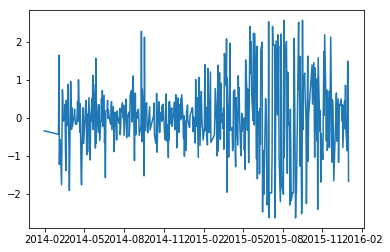

In [36]:
# diagnise
stdresid=model.resid/math.sqrt(model.sigma2)
plt.plot(stdresid)

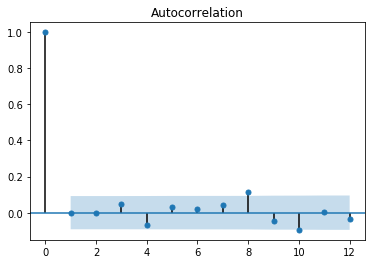

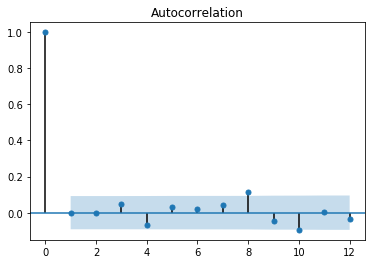

In [37]:
plot_acf(stdresid,lags=12)

In [39]:
LB=stattools.q_stat(stattools.acf(stdresid)[1:12],len(stdresid))
LB[1]
# so the residues do not have autocorrelation and it is a white noise series

array([ 0.99403634,  0.9995103 ,  0.77556433,  0.53779996,  0.60674717,
        0.69723692,  0.70864821,  0.21276688,  0.22902475,  0.10008502,
        0.1410863 ])